# WiFI CSI CNN accuracy comparison with and without phase data.

by Samuel Mclean

## Real Numbers Only Model:

### Data loading and filtering for easier testing

Firstly I am loading all of the data and then sampling 20000 of sit and stand data and outputting it as a new dataframe

consolidated_data.csv is found in the guardian onedrive if you would like to run this code yourself

In [1]:
import pandas as pd

# Load the DataFrame from a CSV file
df = pd.read_csv('consolidated_data.csv')

# Filter rows where the last column is 'sit' and randomly sample 20,000 of them
kneel_samples = df[df.iloc[:, -1] == 'kneel'].sample(n=10000, random_state=1)

# Filter rows where the last column is 'stand' and randomly sample 20,000 of them
sit_samples = df[df.iloc[:, -1] == 'sit'].sample(n=10000, random_state=1)

# Filter rows where the last column is 'sit' and randomly sample 20,000 of them
stand_samples = df[df.iloc[:, -1] == 'stand'].sample(n=10000, random_state=1)

# Filter rows where the last column is 'stand' and randomly sample 20,000 of them
walk_samples = df[df.iloc[:, -1] == 'walk'].sample(n=10000, random_state=1)

# Concatenate the sampled 'sit' and 'stand' DataFrames
result_df = pd.concat([kneel_samples, sit_samples, stand_samples, walk_samples])

# Save the sampled DataFrame to a new CSV file
result_df.to_csv('sampled_data_complex.csv', index=False)

print("Sampled DataFrame saved to 'sampled_data_complex.csv'.")

Sampled DataFrame saved to 'sampled_data_complex.csv'.


### Preprocessing

Here I load a dataset I made from the original data. It contains 10000 sit, stand, kneel and walk data points to make it smaller and easier to work with to prove my point.

Firstly In this I am removing all of the imaginary components of the data then I am Preprocessing via scaling and encoding.

In [2]:
%reset -f
# To unload the large file from memory
import pandas as pd
import re

# Function to extract the real component from complex number strings
def extract_real_part(s):
    if isinstance(s, str):
        # Use a regular expression to isolate the real part of numbers possibly in scientific notation
        match = re.search(r'([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)[+-]', s)
        if match:
            return match.group(1)  # Return the real part found before the '+-' of the imaginary part
        return s  # Return the original string if no match
    return s  # Return unchanged if not a string

# Load the CSV file
df = pd.read_csv('sampled_data_complex.csv')

# Apply the function to each element in the DataFrame except the last column
for column in df.columns[:-1]:  # Exclude the last column
    df[column] = df[column].apply(extract_real_part)

# Save the modified DataFrame back to a CSV file
df.to_csv('sampled_data_real.csv', index=False)
print("done")

done


In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the data
df = pd.read_csv('sampled_data_real.csv')

# Handling missing values if there are any
# df = df.dropna()  # Option to drop missing values
# df.fillna(method='ffill', inplace=True)  # Or forward fill them

# Feature Scaling
scaler = StandardScaler()
# Assuming all columns except the last are features
features = df.columns[:-1]
df[features] = scaler.fit_transform(df[features])

# One-hot encode the target using pandas get_dummies
df_encoded = pd.get_dummies(df, columns=['activity'])

# Check the transformed data
print(df_encoded.shape)

(40000, 94)


### PCA 

For the PCA I picked to do it to 8 principle components as I found it captured almost 96% of the variance, which is more than sufficent for proving my point of it being worth including the phase data (imaginary component of phase).

In [4]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming you already have df_encoded from the previous code that includes one-hot encoded activity columns

# Feature Scaling
scaler = StandardScaler()
# Extract numerical feature columns (excluding the newly created one-hot encoded columns)
features = df_encoded.columns.difference(df_encoded.filter(regex='activity_').columns)
df_encoded[features] = scaler.fit_transform(df_encoded[features])

# Initialize PCA and specify the number of components (increased from 3 to 8)
pca = PCA(n_components=8)

# Apply PCA to the features only, excluding the one-hot encoded target 'activity' columns
principal_components = pca.fit_transform(df_encoded[features])

# Create a DataFrame for the principal components
df_pca = pd.DataFrame(data=principal_components, columns=['PC{}'.format(i) for i in range(1, 9)])  # Adjust column names

# Concatenate the principal components with the one-hot encoded target columns
activity_columns = df_encoded.filter(regex='activity_').columns
df_pca = pd.concat([df_pca, df_encoded[activity_columns].reset_index(drop=True)], axis=1)

# Print the variance ratio of the first 8 principal components
print("Variance captured by the first 8 PCA components:")
print(pca.explained_variance_ratio_)

# Calculate and print the total variance captured by the first 8 components
total_variance = sum(pca.explained_variance_ratio_)
print("Total variance captured by the first 8 components:", total_variance)

# Optionally, you can also save or display the new DataFrame
print(df_pca.head())


Variance captured by the first 8 PCA components:
[0.30936202 0.27367446 0.18876728 0.06321362 0.05854326 0.03703431
 0.02334358 0.01361069]
Total variance captured by the first 8 components: 0.9675492075979018
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  5.737545  4.110967 -0.699024  5.577863  0.983632 -0.516304 -0.491576   
1 -9.691366 -5.136224  4.229821 -2.866539 -1.820472 -1.568020  2.350221   
2  4.764438 -2.893779 -1.532031  0.417637  3.253598  0.536155 -1.775229   
3  5.323625 -0.360877 -0.591261 -0.209655  3.198887  0.055224 -2.071379   
4 -4.935171  1.201880  3.921802  0.281766 -2.484803 -2.044012 -0.080770   

        PC8  activity_kneel  activity_sit  activity_stand  activity_walk  
0  0.395533            True         False           False          False  
1 -0.139849            True         False           False          False  
2 -0.624429            True         False           False          False  
3 -0.090447            True         Fal

# Model Set up

I set up a CCN model on the PCA data, having it run until it stops improving or begins overfitting.

In [5]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Assuming df_pca already includes the PCA components and one-hot encoded target variables

# Identify feature columns (principal components) and target columns
feature_columns = [col for col in df_pca if col.startswith('PC')]
target_columns = df_pca.filter(regex='activity_').columns

# Prepare data for model input
X = df_pca[feature_columns].values.reshape(-1, len(feature_columns), 1)  # Reshape data to fit Conv1D input
y = df_pca[target_columns].values  # One-hot encoded target columns

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Example model assuming the number of principal components you have (e.g., 8)
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')  # Output layer size based on the number of target classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

start_time = time.time()  # Start timing
# Training the model with validation data and early stopping
# Adjust epochs and batch_size as necessary
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])
elapsed_time = time.time() - start_time  # Calculate elapsed time
print(f"Loading results_run1 took {elapsed_time} seconds.")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 8, 64)             256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 4, 128)            24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 2, 128)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 100)               2

This model works very well, now I will repeat but using phase data to see how the accuracy compares.

250/250 [==============================] - 1s 1ms/step
Accuracy: 0.95025
Precision: 0.950642664038242
Recall: 0.95025
F1 Score: 0.950262278907971

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      2047
           1       0.92      0.96      0.94      1967
           2       0.94      0.94      0.94      1986
           3       0.96      0.92      0.94      2000

    accuracy                           0.95      8000
   macro avg       0.95      0.95      0.95      8000
weighted avg       0.95      0.95      0.95      8000



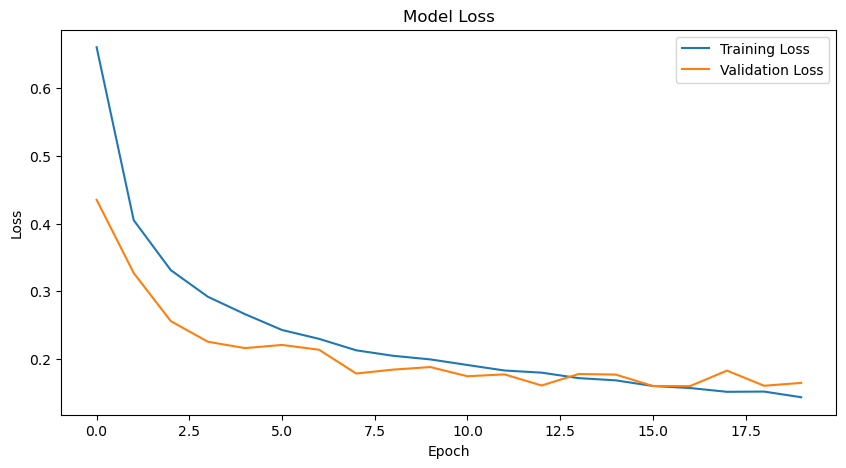

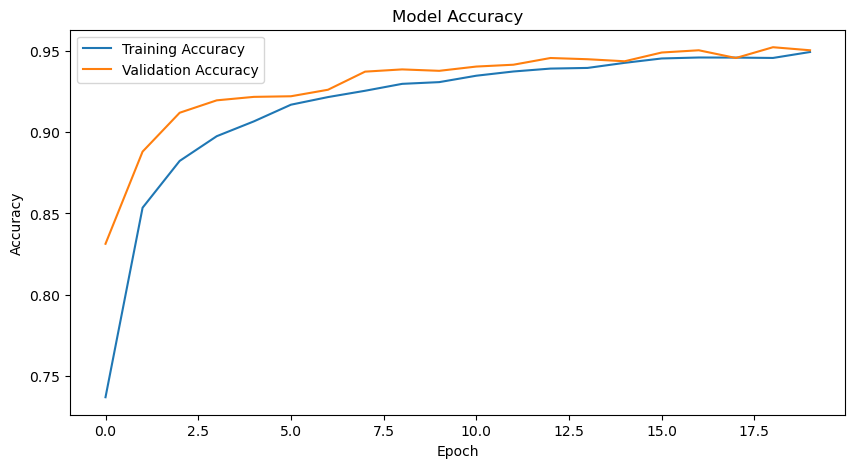

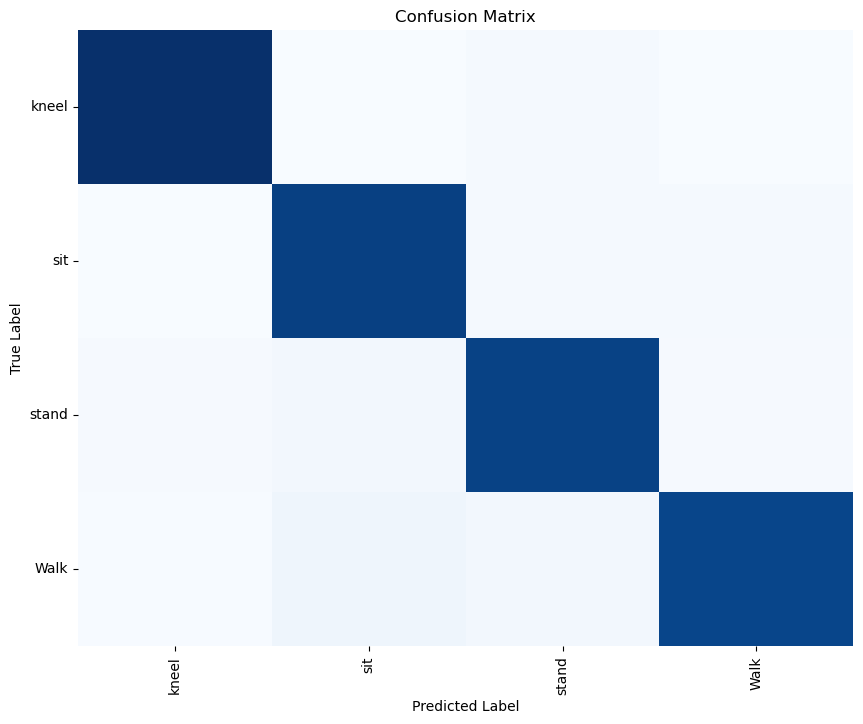

In [6]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Predict probabilities for the validation set
y_val_pred_prob = model.predict(X_val)

# Convert probabilities to class labels
y_val_pred = np.argmax(y_val_pred_prob, axis=1)
y_val_true = np.argmax(y_val, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val_true, y_val_pred)
# Calculate other performance metrics
accuracy = accuracy_score(y_val_true, y_val_pred)
precision, recall, fscore, _ = precision_recall_fscore_support(y_val_true, y_val_pred, average='weighted')
class_report = classification_report(y_val_true, y_val_pred)

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", fscore)
print("\nClassification Report:\n", class_report)

# Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot confusion matrix as a heatmap
class_names = ['kneel', 'sit', 'stand', "Walk"]

# Plot training & validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
ax.set_xticklabels(class_names, rotation=90)  # Rotate x labels for better readability
ax.set_yticklabels(class_names, rotation=0)  # Keep y labels horizontal
plt.show()

All the metrics look great and so does the confusion matrix. Now we redo this but use the Phase data as well.

In [7]:
import pandas as pd
import numpy as np

# Assuming y_val_pred, y_val_true, y_val_pred_prob, and elapsed_time are already defined

# Convert numpy arrays to pandas series for easier DataFrame creation
true_labels_series = pd.Series(np.argmax(y_val, axis=1), name='True Labels')
predicted_labels_series = pd.Series(np.argmax(y_val_pred_prob, axis=1), name='Predicted Labels')
predicted_probabilities_series = pd.Series(np.max(y_val_pred_prob, axis=1), name='Max Predicted Probability')

# Assume elapsed_time is a float or integer representing the time taken for some process
elapsed_time_series = pd.Series([elapsed_time] * len(true_labels_series), name='Elapsed Time')

# Create a DataFrame
results_df = pd.DataFrame({
    'True Labels': true_labels_series,
    'Predicted Labels': predicted_labels_series,
    'Max Predicted Probability': predicted_probabilities_series,
    'Elapsed Time': elapsed_time_series
})

# Save to CSV
results_df.to_csv('model_predictions_real.csv', index=False)
print("Model predictions, probabilities, and elapsed time saved to 'model_predictions_real.csv'.")

Model predictions, probabilities, and elapsed time saved to 'model_predictions_real.csv'.


## Full Complex number usage model:

In [8]:
%reset -f

### Preprocessing

Once again I am preprocessing the data but this time I am separating the complex number into the real and imaginary components to be used later on.

In [9]:
import pandas as pd
import re

# Function to extract real and imaginary parts from complex number strings
def extract_components(s):
    if isinstance(s, str):
        # Use a regular expression to find real and imaginary parts
        match = re.search(r'([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)([+-]\d*\.?\d+(?:[eE][+-]?\d+)?)i', s)
        if match:
            # Extract real and imaginary parts
            real_part = float(match.group(1))
            imaginary_part = float(match.group(2).replace('i', ''))
            return real_part, imaginary_part
        return None  # If no complex number format is found
    return None  # Return None if input is not a string

# Load the CSV file
df = pd.read_csv('sampled_data_complex.csv')

# Prepare new DataFrame to store real and imaginary parts
new_columns = {}
for column in df.columns:
    # Apply the function to each element in the column
    df[column].dropna(inplace=True)  # Drop NaN values that can't be converted
    extracted = df[column].apply(extract_components)
    real_part = extracted.apply(lambda x: x[0] if x else None)
    imaginary_part = extracted.apply(lambda x: x[1] if x else None)
    new_columns[f"{column}_real"] = real_part
    new_columns[f"{column}_imag"] = imaginary_part

# Create a new DataFrame from the processed columns
new_df = pd.DataFrame(new_columns)

# Save the modified DataFrame back to a CSV file
new_df.to_csv('sampled_data_real_imag.csv', index=False)
print("Data preparation complete.")

Data preparation complete.


In [10]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the data
df = pd.read_csv('sampled_data_real.csv')

# Handling missing values if there are any
# df = df.dropna()  # Option to drop missing values
# df.fillna(method='ffill', inplace=True)  # Or forward fill them

# Feature Scaling
scaler = StandardScaler()
# Assuming all columns except the last are features
features = df.columns[:-1]
df[features] = scaler.fit_transform(df[features])

# One-hot encode the target using pandas get_dummies
df_encoded = pd.get_dummies(df, columns=['activity'])

# Check the transformed data
print(df_encoded.shape)

(40000, 94)


### PCA 

Once again, I PCA to 8 components, which captures 96% of the variance again; all is looking good.

In [11]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming you already have df_encoded from the previous code that includes one-hot encoded activity columns

# Feature Scaling
scaler = StandardScaler()
# Extract numerical feature columns (excluding the newly created one-hot encoded columns)
features = df_encoded.columns.difference(df_encoded.filter(regex='activity_').columns)
df_encoded[features] = scaler.fit_transform(df_encoded[features])

# Initialize PCA and specify the number of components (increased from 3 to 8)
pca = PCA(n_components=8)

# Apply PCA to the features only, excluding the one-hot encoded target 'activity' columns
principal_components = pca.fit_transform(df_encoded[features])

# Create a DataFrame for the principal components
df_pca = pd.DataFrame(data=principal_components, columns=['PC{}'.format(i) for i in range(1, 9)])  # Adjust column names

# Concatenate the principal components with the one-hot encoded target columns
activity_columns = df_encoded.filter(regex='activity_').columns
df_pca = pd.concat([df_pca, df_encoded[activity_columns].reset_index(drop=True)], axis=1)

# Print the variance ratio of the first 8 principal components
print("Variance captured by the first 8 PCA components:")
print(pca.explained_variance_ratio_)

# Calculate and print the total variance captured by the first 8 components
total_variance = sum(pca.explained_variance_ratio_)
print("Total variance captured by the first 8 components:", total_variance)

# Optionally, you can also save or display the new DataFrame
print(df_pca.head())

Variance captured by the first 8 PCA components:
[0.30936202 0.27367446 0.18876728 0.06321362 0.05854326 0.03703431
 0.02334358 0.01361069]
Total variance captured by the first 8 components: 0.9675492075979026
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  5.737545  4.110967 -0.699024  5.577863  0.983632 -0.516304 -0.491576   
1 -9.691366 -5.136224  4.229821 -2.866539 -1.820472 -1.568020  2.350221   
2  4.764438 -2.893779 -1.532031  0.417637  3.253598  0.536155 -1.775229   
3  5.323625 -0.360877 -0.591261 -0.209655  3.198887  0.055224 -2.071379   
4 -4.935171  1.201880  3.921802  0.281766 -2.484803 -2.044012 -0.080770   

        PC8  activity_kneel  activity_sit  activity_stand  activity_walk  
0  0.395533            True         False           False          False  
1 -0.139849            True         False           False          False  
2 -0.624429            True         False           False          False  
3 -0.090447            True         Fal

# Model Set up

I set up a CCN model on the PCA data, having it run until it stops improving or begins overfitting.

In [12]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Assuming df_pca already includes the PCA components and one-hot encoded target variables

# Identify feature columns (principal components) and target columns
feature_columns = [col for col in df_pca if col.startswith('PC')]
target_columns = df_pca.filter(regex='activity_').columns

# Prepare data for model input
X = df_pca[feature_columns].values.reshape(-1, len(feature_columns), 1)  # Reshape data to fit Conv1D input
y = df_pca[target_columns].values  # One-hot encoded target columns

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Example model assuming the number of principal components you have (e.g., 8)
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')  # Output layer size based on the number of target classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

start_time = time.time()  # Start timing
# Training the model with validation data and early stopping
# Adjust epochs and batch_size as necessary
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])
elapsed_time = time.time() - start_time  # Calculate elapsed time
print(f"Loading results_run1 took {elapsed_time} seconds.")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 8, 64)             256       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 4, 64)            0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 4, 128)            24704     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 2, 128)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 100)              

This model works very well, now I will repeat but using phase data to see how the accuracy compares.

250/250 [==============================] - 1s 1ms/step
Accuracy: 0.95225
Precision: 0.952304458012165
Recall: 0.95225
F1 Score: 0.9522605520904349

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      2047
           1       0.94      0.94      0.94      1967
           2       0.94      0.95      0.95      1986
           3       0.95      0.94      0.94      2000

    accuracy                           0.95      8000
   macro avg       0.95      0.95      0.95      8000
weighted avg       0.95      0.95      0.95      8000



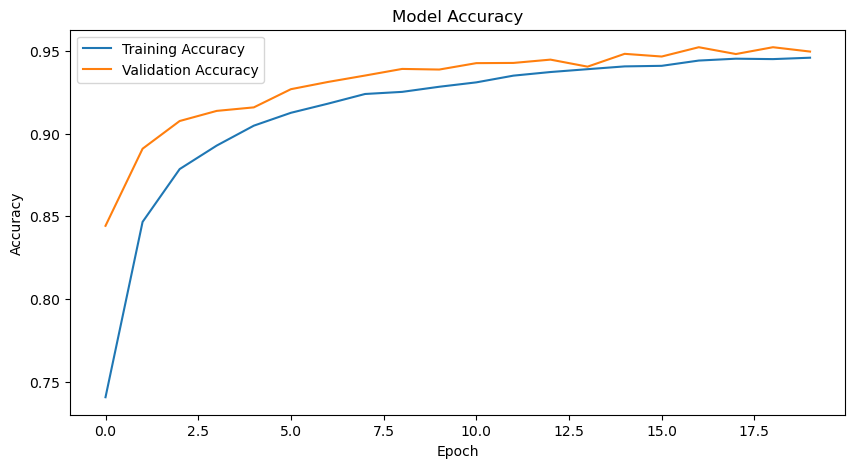

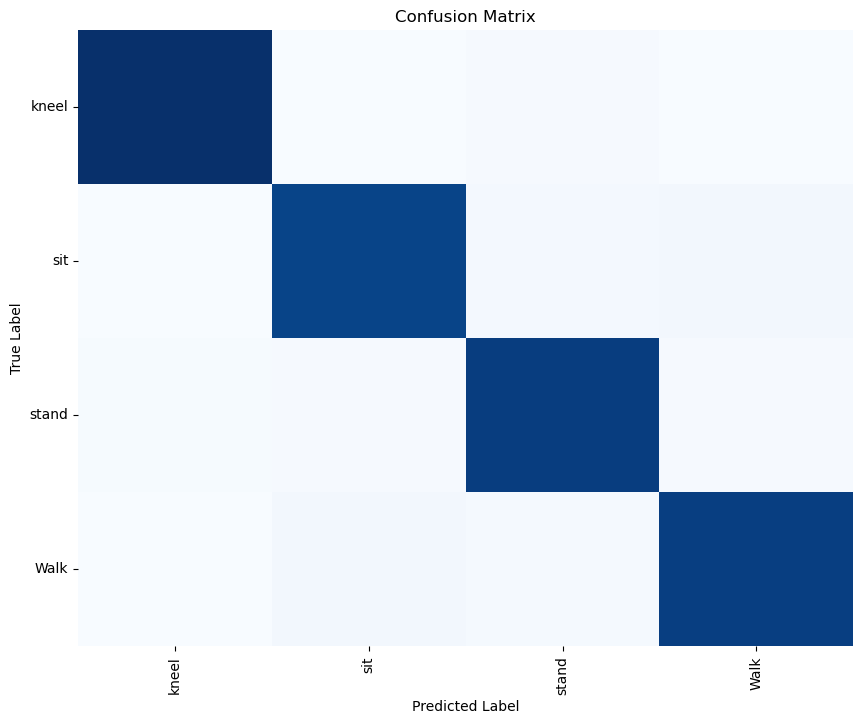

In [13]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Predict probabilities for the validation set
y_val_pred_prob = model.predict(X_val)

# Convert probabilities to class labels
y_val_pred = np.argmax(y_val_pred_prob, axis=1)
y_val_true = np.argmax(y_val, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val_true, y_val_pred)
# Calculate other performance metrics
accuracy = accuracy_score(y_val_true, y_val_pred)
precision, recall, fscore, _ = precision_recall_fscore_support(y_val_true, y_val_pred, average='weighted')
class_report = classification_report(y_val_true, y_val_pred)

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", fscore)
print("\nClassification Report:\n", class_report)

# Plot training & validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot confusion matrix as a heatmap
class_names = ['kneel', 'sit', 'stand', "Walk"]

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
ax.set_xticklabels(class_names, rotation=90)  # Rotate x labels for better readability
ax.set_yticklabels(class_names, rotation=0)  # Keep y labels horizontal
plt.show()


In [14]:
import pandas as pd
import numpy as np

# Assuming y_val_pred, y_val_true, y_val_pred_prob, and elapsed_time are already defined

# Convert numpy arrays to pandas series for easier DataFrame creation
true_labels_series = pd.Series(np.argmax(y_val, axis=1), name='True Labels')
predicted_labels_series = pd.Series(np.argmax(y_val_pred_prob, axis=1), name='Predicted Labels')
predicted_probabilities_series = pd.Series(np.max(y_val_pred_prob, axis=1), name='Max Predicted Probability')

# Assume elapsed_time is a float or integer representing the time taken for some process
elapsed_time_series = pd.Series([elapsed_time] * len(true_labels_series), name='Elapsed Time')

# Create a DataFrame
results_df = pd.DataFrame({
    'True Labels': true_labels_series,
    'Predicted Labels': predicted_labels_series,
    'Max Predicted Probability': predicted_probabilities_series,
    'Elapsed Time': elapsed_time_series
})

# Save to CSV
results_df.to_csv('model_predictions_real_imag.csv', index=False)

print("Model predictions, probabilities, and elapsed time saved to 'model_predictions_real_imag.csv'.")

Model predictions, probabilities, and elapsed time saved to 'model_predictions_real_imag.csv'.


## Comparison

In [15]:
%reset -f

Model: Real numbers
Model: Complex numbers


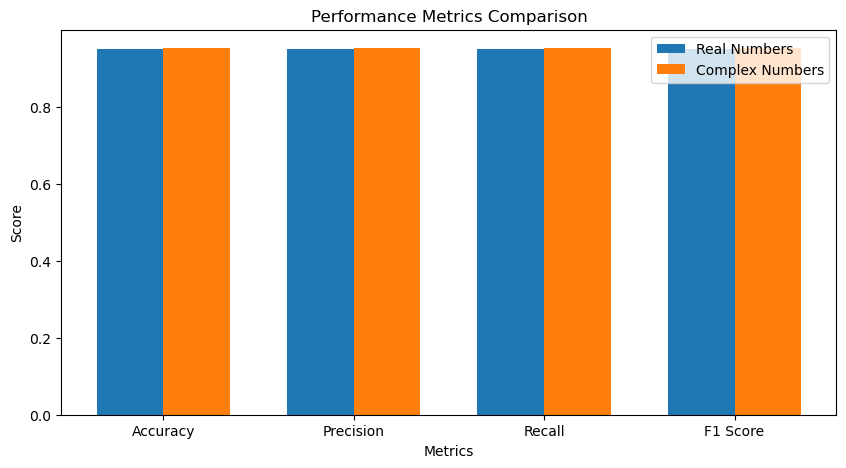

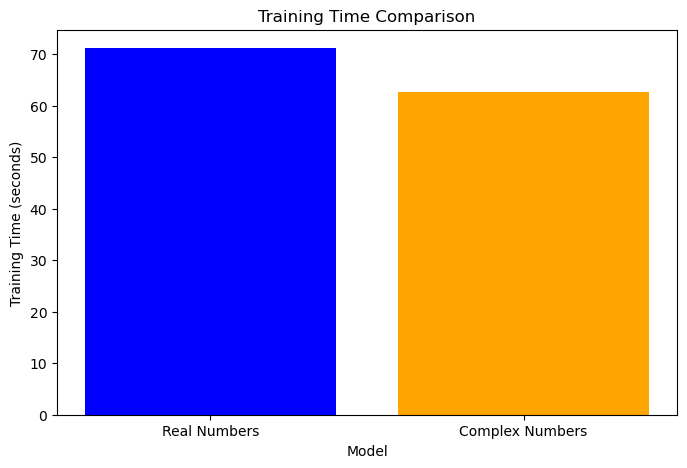

Comparison of Metrics and Training Time between Real and Complex models:
Accuracy: Complex model is 0.21% better than Real model
Precision: Complex model is 0.17% better than Real model
Recall: Complex model is 0.21% better than Real model
F1 Score: Complex model is 0.21% better than Real model
Training Time: Complex model takes 11.92% less time than Real model


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix

df_real = pd.read_csv('model_predictions_real.csv')
df_complex = pd.read_csv('model_predictions_real_imag.csv')

real_train_time = df_real["Elapsed Time"][0]
real_y_true = df_real["True Labels"]
real_y_pred = df_real["Predicted Labels"]
complex_train_time = df_complex["Elapsed Time"][0]
complex_y_true = df_complex["True Labels"]
complex_y_pred = df_complex["Predicted Labels"]

def calc_metrics(model_name, y_val_true, y_val_pred):
    print(f"Model: {model_name}")
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_val_true, y_val_pred)
    # Calculate other performance metrics
    accuracy = accuracy_score(y_val_true, y_val_pred)
    precision, recall, fscore, _ = precision_recall_fscore_support(y_val_true, y_val_pred, average='weighted')
    class_report = classification_report(y_val_true, y_val_pred, output_dict=True)
    
    # Return the metrics
    return {
        "Model": model_name,
        "Confusion Matrix": conf_matrix,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": fscore,
        "Classification Report": class_report
    }

# Calculate metrics for both models
real_metrics = calc_metrics("Real numbers", real_y_true, real_y_pred)
complex_metrics = calc_metrics("Complex numbers", complex_y_true, complex_y_pred)

# Extract metrics for plotting
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
real_metrics_values = [real_metrics['Accuracy'], real_metrics['Precision'], real_metrics['Recall'], real_metrics['F1 Score']]
complex_metrics_values = [complex_metrics['Accuracy'], complex_metrics['Precision'], complex_metrics['Recall'], complex_metrics['F1 Score']]

# Plot bar graph for performance metrics
plt.figure(figsize=(10, 5))
bar_width = 0.35
index = np.arange(len(metrics_names))
plt.bar(index, real_metrics_values, bar_width, label='Real Numbers')
plt.bar(index + bar_width, complex_metrics_values, bar_width, label='Complex Numbers')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Performance Metrics Comparison')
plt.xticks(index + bar_width / 2, metrics_names)
plt.legend()
plt.show()

# Plot bar graph for training time
plt.figure(figsize=(8, 5))
train_times = [real_train_time, complex_train_time]
models = ['Real Numbers', 'Complex Numbers']
plt.bar(models, train_times, color=['blue', 'orange'])
plt.xlabel('Model')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time Comparison')
plt.show()

def compare_metrics(real_metrics, complex_metrics, real_train_time, complex_train_time):
    print("Comparison of Metrics and Training Time between Real and Complex models:")
    
    # Compare performance metrics
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    for metric in metrics_names:
        real_metric_value = real_metrics[metric]
        complex_metric_value = complex_metrics[metric]
        improvement = ((complex_metric_value - real_metric_value) / real_metric_value) * 100
        print(f"{metric}: Complex model is {improvement:.2f}% better than Real model")

    # Compare training time
    improvement_time = ((complex_train_time - real_train_time) / real_train_time) * 100
    print(f"Training Time: Complex model takes {-improvement_time:.2f}% less time than Real model")

# Call the function to compare metrics
compare_metrics(real_metrics, complex_metrics, real_train_time, complex_train_time)

### Conclusion

The comparison between models utilizing real and complex numbers in WiFi Channel State Information (CSI) data for patient activity tracking reveals minimal improvements in performance metrics with the inclusion of complex numbers, approximately around 0.2%. However, the complex model trains nearly 12% faster to achieve comparable performance. This significant reduction in training time is crucial for real-world healthcare applications, particularly in patient activity tracking, as it facilitates quicker model deployment and adaptation to new patients or environments.